# AS-AD model

**Table of contents**<a id='toc0_'></a>    
- 1. [Model](#toc1_)    
- 2. [Setup](#toc2_)    
- 3. [Simulate](#toc3_)    
- 4. [Estimate](#toc4_)    
- 5. [Further](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Model](#toc0_)

Consider the following AS-AD model:


1. **AD-curve:** $$y_{t}-\bar{y} = \alpha (\pi^{\ast}-\pi_t) + z_t$$
2. **Short-Run AS curve:** $$\pi_t = \pi^e_t + \gamma (y_t-\bar{y}) + s_t$$
3. **Inflation expectations:** $$ \pi^e_t = \phi \pi^e_{t-1} + (1-\phi)\pi_{t-1}$$
4. **Demand shock:** $$z_{t} = \delta z_{t-1}+x_{t}, x_{t} \sim N(0,\sigma_x^2)$$
5. **Supply shock:** $$s_{t} = \omega s_{t-1}+c_{t}, c_{t} \sim N(0,\sigma_c^2)$$

Define the **output and inflation gaps**:


1. **Output:** $$\hat{y}_{t} = y_t-\bar{y}$$
2. **Inflation:** $$\hat{\pi}_{t} = \pi_t-\pi^{\ast}$$


**After a bit of algebra...** We can write the model as



$$
\begin{aligned}
\hat{y}_{t} &= a\hat{y}_{t-1}+\beta(z_{t}-z_{t-1})-\alpha\beta s_{t}+\alpha\beta\phi s_{t-1} \\
\hat{\pi}_{t} &= a\hat{\pi}_{t-1}+\beta\gamma z_{t}-\beta\phi\gamma z_{t}+\beta s_{t}-\beta\phi s_{t-1} \\
\end{aligned}
$$

where 

$$
\begin{aligned}
a &= \frac{1+\alpha\phi\gamma}{1+\alpha\gamma} \\
\beta &= \frac{1}{1+\alpha\gamma}
\end{aligned}
$$

In **business-cycle data** from the US we have:

1. $std(\hat{y}_t) = 1.64$
2. $std({\hat{\pi}}_t) = 0.21$
3. $corr(\hat{y}_t,{\hat{\pi}}_t) = 0.31$
4. $corr(\hat{y}_t,\hat{y}_{t-1}) = 0.84$
5. $corr({\hat{\pi}}_t,{\hat{\pi}}_{t-1}) = 0.48$

**Task:**

1. Assume you have external evidence that $\alpha = 0.7$, $\gamma = 0.075$ and $\phi = 0.99$
2. Can you choose the remaining parameter so the model matches the data?

## 2. <a id='toc2_'></a>[Setup](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from ASAD import ASADClass 

In [2]:
model = ASADClass()
par = model.par
sim = model.sim
print(f'{par.a = :.4f}')
print(f'{par.beta = :.4f}')

par.a = 0.9995
par.beta = 0.9501


## 3. <a id='toc3_'></a>[Simulate](#toc0_)

In [3]:
model.simulate()

**Plot output and inflation:**

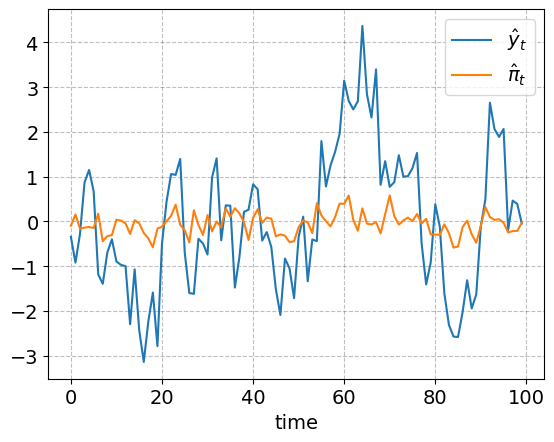

In [4]:
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

**Compare with data:**

In [5]:
model.calc_moms() # calculate moments from the simulation
error = model.calc_diff_to_data(do_print=True) # compares with the data

std_y       | data = 1.6400, model = 1.5748
std_pi      | data = 0.2100, model = 0.2442
corr_y_pi   | data = 0.3100, model = 0.4263
autocorr_y  | data = 0.8400, model = 0.7905
autocorr_pi | data = 0.4800, model = 0.4319
error =   0.02372299


## 4. <a id='toc4_'></a>[Estimate](#toc0_)

We now consider a **structural estimation**. 

**Principle:** Choose parameters to minimize the distance between data moments and simulated model moments.

**Objective:** A measure of the distance between model and data (involves a subjective choice of moments), here:

$$
\begin{align*}
g(\delta,\omega,\sigma_x,\sigma_c) = &\,\,(std(\hat{y}_t^{data}) - std(\hat{y}_t^{model}))^2 \\
& + (std({\hat{\pi}}_t^{data}) - std({\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},{\hat{\pi}}_t^{data}) - corr(\hat{y}_t^{data},{\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},\hat{y}_{t-1}^{data}) - corr(\hat{y}_t^{model},\hat{y}_{t-1}^{model}))^2 \\
& + (corr({\hat{\pi}}_t^{data},{\hat{\pi}}_{t-1}^{data}) - corr({\hat{\pi}}_t^{model},{\hat{\pi}}_{t-1}^{model}))^2 \\
\end{align*}
$$

**Minimization:** Choose the free parameters to minimize the objective, i.e.

$$
\min_{\delta,\omega,\sigma_x,\sigma_c} g(\delta,\omega,\sigma_x,\sigma_c)
$$

In [6]:
def obj(x,parnames,do_print=False):
    """ objective for choosing parameters """

    # a. update parameters
    for xval,parname in zip(x,parnames):
        par.__dict__[parname] = xval
        if do_print: print(f'{parname:10s} = {xval:.4f}')

    if do_print: print('')

    model.calc_compound_par()

    # b. simulate and calculate moments
    model.simulate()
    model.calc_moms()

    # c. compare with data
    error = model.calc_diff_to_data(do_print=do_print)

    return error

**Calculate objective at initial values:**

In [7]:
parnames = ['delta','omega','sigma_x','sigma_c']
x0 = [par.__dict__[parname] for parname in parnames]
error_ = obj(x0,parnames,do_print=True)

delta      = 0.8000
omega      = 0.1500
sigma_x    = 1.0000
sigma_c    = 0.2000

std_y       | data = 1.6400, model = 1.5748
std_pi      | data = 0.2100, model = 0.2442
corr_y_pi   | data = 0.3100, model = 0.4263
autocorr_y  | data = 0.8400, model = 0.7905
autocorr_pi | data = 0.4800, model = 0.4319
error =   0.02372299


**Esimtate:**

In [8]:
bounds = ((0,1-1e-8),(0,1-1e-8),(0,None),(0,None))
res = optimize.minimize(obj,x0,bounds=bounds,method='Nelder-Mead',args=(parnames,))

Ensure the optimization was succesfull:

In [9]:
assert res.success

**Results:**

In [10]:
error_ = obj(res.x,parnames,do_print=True)

delta      = 0.8442
omega      = 0.2463
sigma_x    = 0.9248
sigma_c    = 0.2407

std_y       | data = 1.6400, model = 1.6257
std_pi      | data = 0.2100, model = 0.2899
corr_y_pi   | data = 0.3100, model = 0.3508
autocorr_y  | data = 0.8400, model = 0.8332
autocorr_pi | data = 0.4800, model = 0.4789
error =   0.00830266


**Conclusion:** The model provides a reasonable fit of the data. We have more moments than parameters so a perfect fit is unlikely.

## 5. <a id='toc5_'></a>[Further](#toc0_)

1. Plot AS-AD diagram
2. Plot impulse-response functions for shocks
3. Investigate importance of seed for simulation
4. Investigate importance of starting values for estimation
5. Investigate discrepancies when changing parameters
5. Implement model extensions